In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time
import re
import scipy.stats as stats
from tqdm import tqdm

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

from joblib import Parallel, delayed

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#mne.viz.set_3d_backend('pyvistaqt')

In [2]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

ch_pairs = []
for l,r in zip(chan_left_all, chan_right_all):
    ch_pairs.append(f'{l}-{r}')
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = '/Users/nick/Documents/PhD/3DMOT_BCI/src/'
directory_data = '/Users/nick/Documents/PhD/3DMOT_BCI/data - raw/'
directory_preproc = '/Users/nick/Documents/PhD/3DMOT_BCI/data - preprocessed/'
sep = '/'

# Across/Between Subject Classification

100%|███████████████████████████████████████████████████████████████| 20/20 [10:31<00:00, 29.85s/it]

(4047, 2, 7, 256)


TypeError: dump() missing required argument 'file' (pos 2)

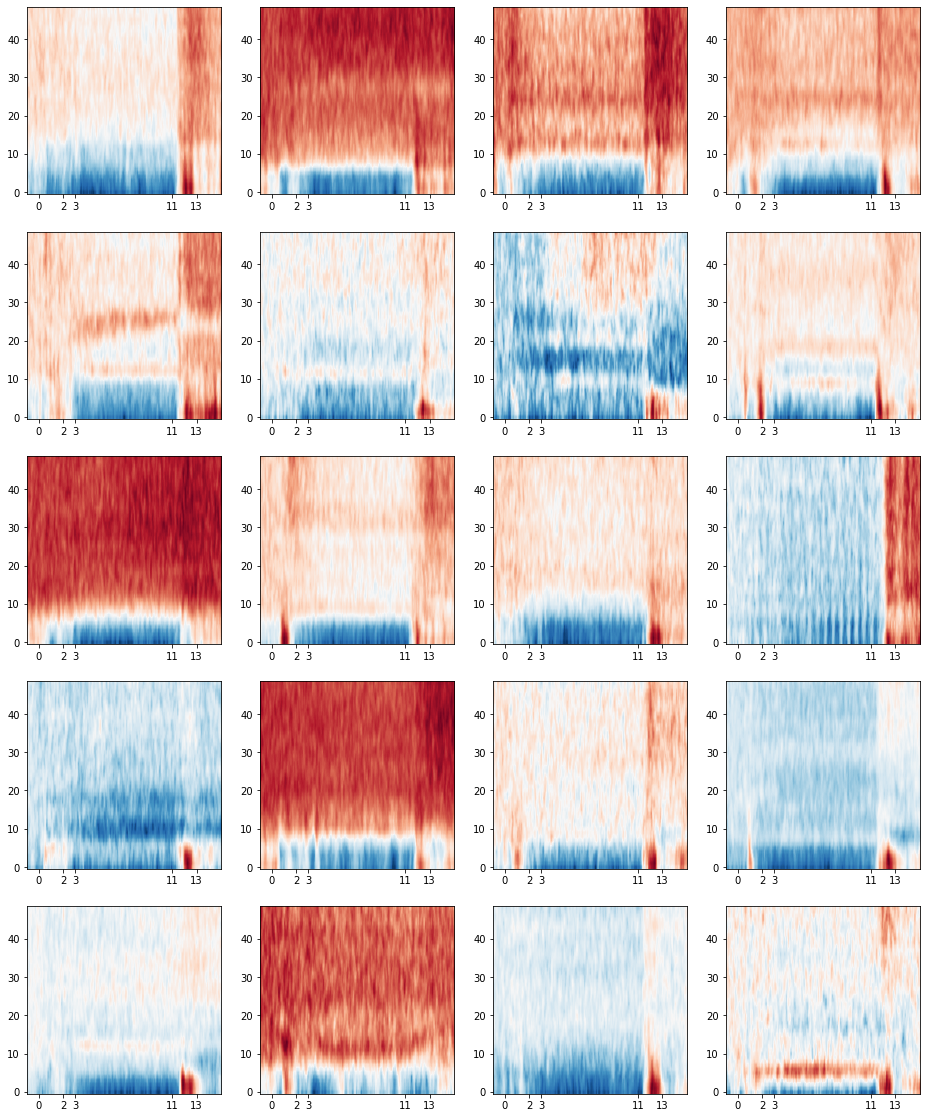

In [3]:
X_trials_all = []
y_all = []

meanpower_dict_all = dict()

fig = plt.figure(figsize=(16, 20))

no_participant = 0

pbar = tqdm(total=20)
for filepath in glob.iglob(directory_preproc + sep + 'ERSP_1-50Hz' + sep + '*.pkl'):
    filename = filepath[filepath.rfind(sep)+1:]
    
    if filename == 'grand_averageTFR.pkl' or filename == 'R1-GrandAverage.pkl':
        continue
    
    with open(filepath, 'rb') as f:
        epochs = pickle.load(f)

    bl_epochs = epochs.apply_baseline((-1,0), mode='logratio', verbose=False).crop(tmin=-1, tmax=15)
    #cur_data = bl_epochs.pick_channels(clusters_chs['Frontal']).data
    cur_data = bl_epochs.pick_channels(['Fpz', 'AFz']).data
    times = bl_epochs.times
    
    ticks_offset = np.where(times >= -1)[0][0]
    times_of_interest = [0, 2, 3, 11, 13]
    ticks_of_interest = [(np.where(times >= t)[0][0] - ticks_offset) for t in times_of_interest]
    
    for trial in cur_data:
        X_trials_all.append(trial[:, 0:7, (times >= 5) & (times <= 6)])
        y_all.append(0)
        X_trials_all.append(trial[:, 0:7, (times >= 11.5) & (times <= 12.5)])
        y_all.append(1)
        X_trials_all.append(trial[:, 0:7, (times >= 0.4) & (times <= 1.4)])
        y_all.append(-1)

    avg_power = np.nanmean(np.nanmean(cur_data, 0), 0)
    
    no_participant = no_participant + 1
    ax = plt.subplot(5, 4, no_participant)
    ax.imshow(avg_power, aspect='auto', origin='lower', cmap=plt.cm.RdBu_r)
    ax.set_xticks(ticks_of_interest)
    ax.set_xticklabels(times_of_interest)
    
    meanpower_dict_all[filename] = avg_power
    
    pbar.update(1)
    del epochs

min_length = min([X_trials_all[0].shape[2], X_trials_all[1].shape[2], X_trials_all[2].shape[2]])
for i, trial in enumerate(X_trials_all):
    if trial.shape[2] != min_length:
        X_trials_all[i] = X_trials_all[i][:,:,:min_length]
        
len(X_trials_all)
X_trials = np.stack(X_trials_all, 0)
print(X_trials.shape)

ml_data = dict()
ml_data['X'] = X_trials
ml_data['y'] = y_all
with open(directory_preproc + sep + 'ml-freq' + sep + 'ml-phases-AFz-Fpz.pkl', 'wb') as f:
    pickle.dump(ml_data, f)
    
plt.show()

In [5]:
X_trials = X_trials.reshape(4047, X_trials.shape[1] * X_trials.shape[2] * X_trials.shape[3])
print(X_trials.shape)

(4047, 3584)


In [6]:
y_all = np.array(y_all)
print(len(y_all))

clf = make_pipeline(SVC())
scores = cross_val_multiscore(clf, X_trials, y_all, cv=10, n_jobs=10)
print(scores)
print(scores.mean(0)) # ~56.33%

4047


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   50.1s remaining:  1.9min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:   50.1s remaining:   33.4s


[0.61728395 0.62962963 0.55555556 0.5037037  0.56790123 0.56049383
 0.57530864 0.58663366 0.48762376 0.54455446]
0.5628688424397996


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   50.8s finished


In [7]:
# 1 vs 0: 80%+
# 1 vs -1: 65%+
# 0 vs -1: 70%+

X_trials_subs = X_trials[y_all != -1]
y_all_subs = y_all[y_all != -1]

clf = make_pipeline(SVC())
scores = cross_val_multiscore(clf, X_trials_subs, y_all_subs, cv=5, n_jobs=10)
print(scores)
print(scores.mean(0)) # ~80%

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s


[0.85740741 0.77407407 0.79259259 0.81261596 0.70500928]
0.7883398611970039


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    6.9s finished


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_49820/2830697818.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+phases)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_49820/2830697818.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+phases)


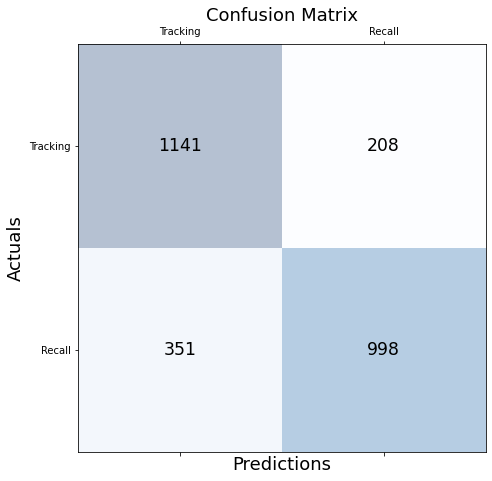

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(clf, X_trials_subs, y_all_subs, cv=10, n_jobs=10)
conf_mat = confusion_matrix(y_all_subs, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', size='xx-large')

phases = ['Tracking', 'Recall']

ax.set_xticklabels(['']+phases)
ax.set_yticklabels(['']+phases)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

fig.savefig('3D-MOT_PhaseClassif_ConfMatrix.png', dpi=300, format='png') 

plt.show()

In [12]:
TP = conf_mat[0,0]
FP = conf_mat[0,1]
TN = conf_mat[1,1]
FN = conf_mat[1,0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
sensitivity = (TP)/(TP+FN)
specificity = (TN)/(FP+TN)

print('Acc: {:.2f}%, Sens: {:.2f}%, Spec: {:.2f}%'.format(accuracy, sensitivity, specificity))

Acc: 0.79%, Sens: 0.76%, Spec: 0.83%


### Within Subject Classification

In [25]:
scores_all = dict()

pbar = tqdm(total=20)
for filepath in glob.iglob(directory_preproc + sep + 'ERSP_1-50Hz' + sep + '*.pkl'):
    filename = filepath[filepath.rfind(sep)+1:]
    
    if filename == 'grand_averageTFR.pkl' or filename == 'R1-GrandAverage.pkl':
        continue
    
    with open(filepath, 'rb') as f:
        epochs = pickle.load(f)

    # Reset Variables for ML.
    X_trials_all = []
    y_all = []

    bl_epochs = epochs.apply_baseline((-1,0), mode='logratio', verbose=False).crop(tmin=-1, tmax=15)
    cur_data = bl_epochs.pick_channels(clusters_chs['Frontal']).data
    times = bl_epochs.times
    
    for trial in cur_data:
        X_trials_all.append(trial[:, 0:7, (times >= 5) & (times <= 6)])
        y_all.append(0)
        X_trials_all.append(trial[:, 0:7, (times >= 11.5) & (times <= 12.5)])
        y_all.append(1)
        X_trials_all.append(trial[:, 0:7, (times >= 0.4) & (times <= 1.4)])
        y_all.append(-1)
    
    pbar.update(1)
    del epochs
    
    min_length = min([X_trials_all[0].shape[2], X_trials_all[1].shape[2], X_trials_all[2].shape[2]])
    for i, trial in enumerate(X_trials_all):
        if trial.shape[2] != min_length:
            X_trials_all[i] = X_trials_all[i][:,:,:min_length]

    y_all = np.array(y_all)    
    
    len(X_trials_all)
    X_trials = np.stack(X_trials_all, 0)
    print(X_trials.shape)
    
    X_trials = X_trials.reshape(X_trials.shape[0], X_trials.shape[1] * X_trials.shape[2] * X_trials.shape[3])
    print(X_trials.shape)
    
    X_trials_subs = X_trials[y_all != -1].squeeze()
    y_all_subs = y_all[y_all != -1].squeeze()

    clf = make_pipeline(SVC())
    scores = cross_val_multiscore(clf, X_trials_subs, y_all_subs, cv=5, n_jobs=5)
    print(scores)
    print(scores.mean(0)) # ~80%

    scores_all[filename] = scores


  5%|███▏                                                           | 1/20 [02:18<43:42, 138.01s/it]

  5%|███▏                                                            | 1/20 [00:26<08:27, 26.69s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(183, 19, 7, 256)
(183, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


[0.92       0.88       0.75       0.875      0.83333333]
0.8516666666666666



 10%|██████▍                                                         | 2/20 [01:20<12:48, 42.69s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(237, 19, 7, 256)
(237, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


[0.8125     0.9375     0.90625    0.77419355 0.83870968]
0.8538306451612904



 15%|█████████▌                                                      | 3/20 [01:31<08:01, 28.31s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished


(81, 19, 7, 256)
(81, 34048)
[0.72727273 0.72727273 0.72727273 0.81818182 0.7       ]
0.74



 20%|████████████▊                                                   | 4/20 [02:00<07:35, 28.44s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(195, 19, 7, 256)
(195, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


[1.         0.92307692 0.88461538 1.         0.92307692]
0.9461538461538461



 25%|████████████████                                                | 5/20 [02:21<06:25, 25.69s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(150, 19, 7, 256)
(150, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.5s finished


[0.9  0.9  0.95 0.85 0.8 ]
0.8800000000000001



 30%|███████████████████▏                                            | 6/20 [02:58<06:55, 29.68s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(204, 19, 7, 256)
(204, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


[0.75       0.7037037  0.92592593 0.92592593 0.85185185]
0.8314814814814815



 35%|██████████████████████▍                                         | 7/20 [03:22<06:02, 27.85s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(165, 19, 7, 256)
(165, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.6s finished


[0.86363636 0.72727273 0.77272727 0.90909091 0.90909091]
0.8363636363636363



 40%|█████████████████████████▌                                      | 8/20 [04:54<09:37, 48.14s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(282, 19, 7, 256)
(282, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.3s finished


[0.65789474 0.76315789 0.86842105 0.75675676 0.81081081]
0.7714082503556189



 45%|████████████████████████████▊                                   | 9/20 [05:59<09:49, 53.58s/it]

(249, 19, 7, 256)
(249, 34048)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished


[0.76470588 0.84848485 0.60606061 0.63636364 0.81818182]
0.73475935828877



 50%|███████████████████████████████▌                               | 10/20 [06:53<08:56, 53.61s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(231, 19, 7, 256)
(231, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


[0.93548387 0.96774194 0.96774194 0.90322581 0.83333333]
0.921505376344086



 55%|██████████████████████████████████▋                            | 11/20 [07:35<07:30, 50.05s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(222, 19, 7, 256)
(222, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


[0.76666667 0.86666667 0.73333333 0.86206897 0.86206897]
0.8181609195402298



 60%|█████████████████████████████████████▊                         | 12/20 [07:45<05:02, 37.82s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished


(72, 19, 7, 256)
(72, 34048)
[1.         0.8        1.         0.66666667 0.77777778]
0.8488888888888889



 65%|████████████████████████████████████████▉                      | 13/20 [08:35<04:50, 41.46s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(249, 19, 7, 256)
(249, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished


[0.64705882 0.84848485 0.84848485 0.90909091 0.6969697 ]
0.790017825311943



 70%|████████████████████████████████████████████                   | 14/20 [09:30<04:33, 45.56s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(243, 19, 7, 256)
(243, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


[0.72727273 0.6969697  0.9375     0.8125     0.78125   ]
0.7910984848484849



 75%|███████████████████████████████████████████████▎               | 15/20 [10:16<03:49, 45.91s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(234, 19, 7, 256)
(234, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


[0.96875    0.83870968 0.90322581 0.80645161 0.87096774]
0.8776209677419355



 80%|██████████████████████████████████████████████████▍            | 16/20 [11:21<03:25, 51.37s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(252, 19, 7, 256)
(252, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


[0.94117647 0.94117647 0.85294118 0.93939394 1.        ]
0.9349376114081996



 85%|█████████████████████████████████████████████████████▌         | 17/20 [11:53<02:16, 45.55s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(210, 19, 7, 256)
(210, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.4s finished


[0.89285714 0.92857143 0.92857143 0.89285714 0.85714286]
0.9



 90%|████████████████████████████████████████████████████████▋      | 18/20 [12:40<01:32, 46.28s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(246, 19, 7, 256)
(246, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.3s finished


[0.48484848 0.63636364 0.75757576 0.60606061 0.59375   ]
0.615719696969697



 95%|███████████████████████████████████████████████████████████▊   | 19/20 [12:57<00:37, 37.26s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(117, 19, 7, 256)
(117, 34048)


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.3s finished


[0.8125     0.875      0.875      1.         0.86666667]
0.8858333333333335



100%|███████████████████████████████████████████████████████████████| 20/20 [13:32<00:00, 36.55s/it][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


(225, 19, 7, 256)
(225, 34048)
[0.83333333 0.8        0.86666667 0.86666667 0.8       ]
0.8333333333333334


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


In [36]:
scores_subjs = []
for participant in scores_all.keys():
    print('{}: {:.2f}'.format(participant[8:12], scores_all[participant].mean(0) * 100))
    scores_subjs.append(scores_all[participant].mean(0))
       
scores_subjs = np.array(scores_subjs)
print('Grand Average: {:.2f}'.format(scores_subjs.mean(0) * 100))
print('Min: {:.2f}'.format(scores_subjs.min(0) * 100))
print('Max: {:.2f}'.format(scores_subjs.max(0) * 100))
print('std: {:.2f}'.format(scores_subjs.std(0) * 100))

F12F: 85.17
T23F: 85.38
T18F: 74.00
M22F: 94.62
T9F2: 88.00
T11F: 83.15
F19M: 83.64
S21F: 77.14
M8M1: 73.48
F12M: 92.15
T18M: 81.82
F5M1: 84.89
W17M: 79.00
T23F: 79.11
S20M: 87.76
T25F: 93.49
W10F: 90.00
M8M2: 61.57
F26F: 88.58
T16F: 83.33
Grand Average: 83.31
Min: 61.57
Max: 94.62
std: 7.64
